In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [41]:
# Setting up the FRED API key (replace with your own key)
api_key = '060213f8f9bc0f09d86c251b43f3e1dc'
fred = Fred(api_key=api_key)

In [42]:
try:
    gdp_growth = fred.get_series('A191RL1Q225SBEA')
    inflation = fred.get_series('CPIAUCSL')
    unemployment = fred.get_series('UNRATE')
except Exception as e:
    print(f"Error fetching data: {e}")

In [43]:
# Assuming df is a DataFrame that combines the fetched series
df = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation': inflation,
    'Unemployment': unemployment
})
df.dropna(inplace=True)  # Handle missing values

In [44]:
# Create a dataframe
df = pd.DataFrame({
    'GDP_Growth': gdp_growth,
    'Inflation': inflation,
    'Unemployment': unemployment
})

# Handle missing values and align dates
df = df.dropna()

# Calculate year-over-year inflation rate
df['Inflation'] = df['Inflation'].pct_change(periods=4) * 100

# Ensure all series are quarterly
df = df.resample('Q').last()

# Drop any remaining NaN values
df = df.dropna()

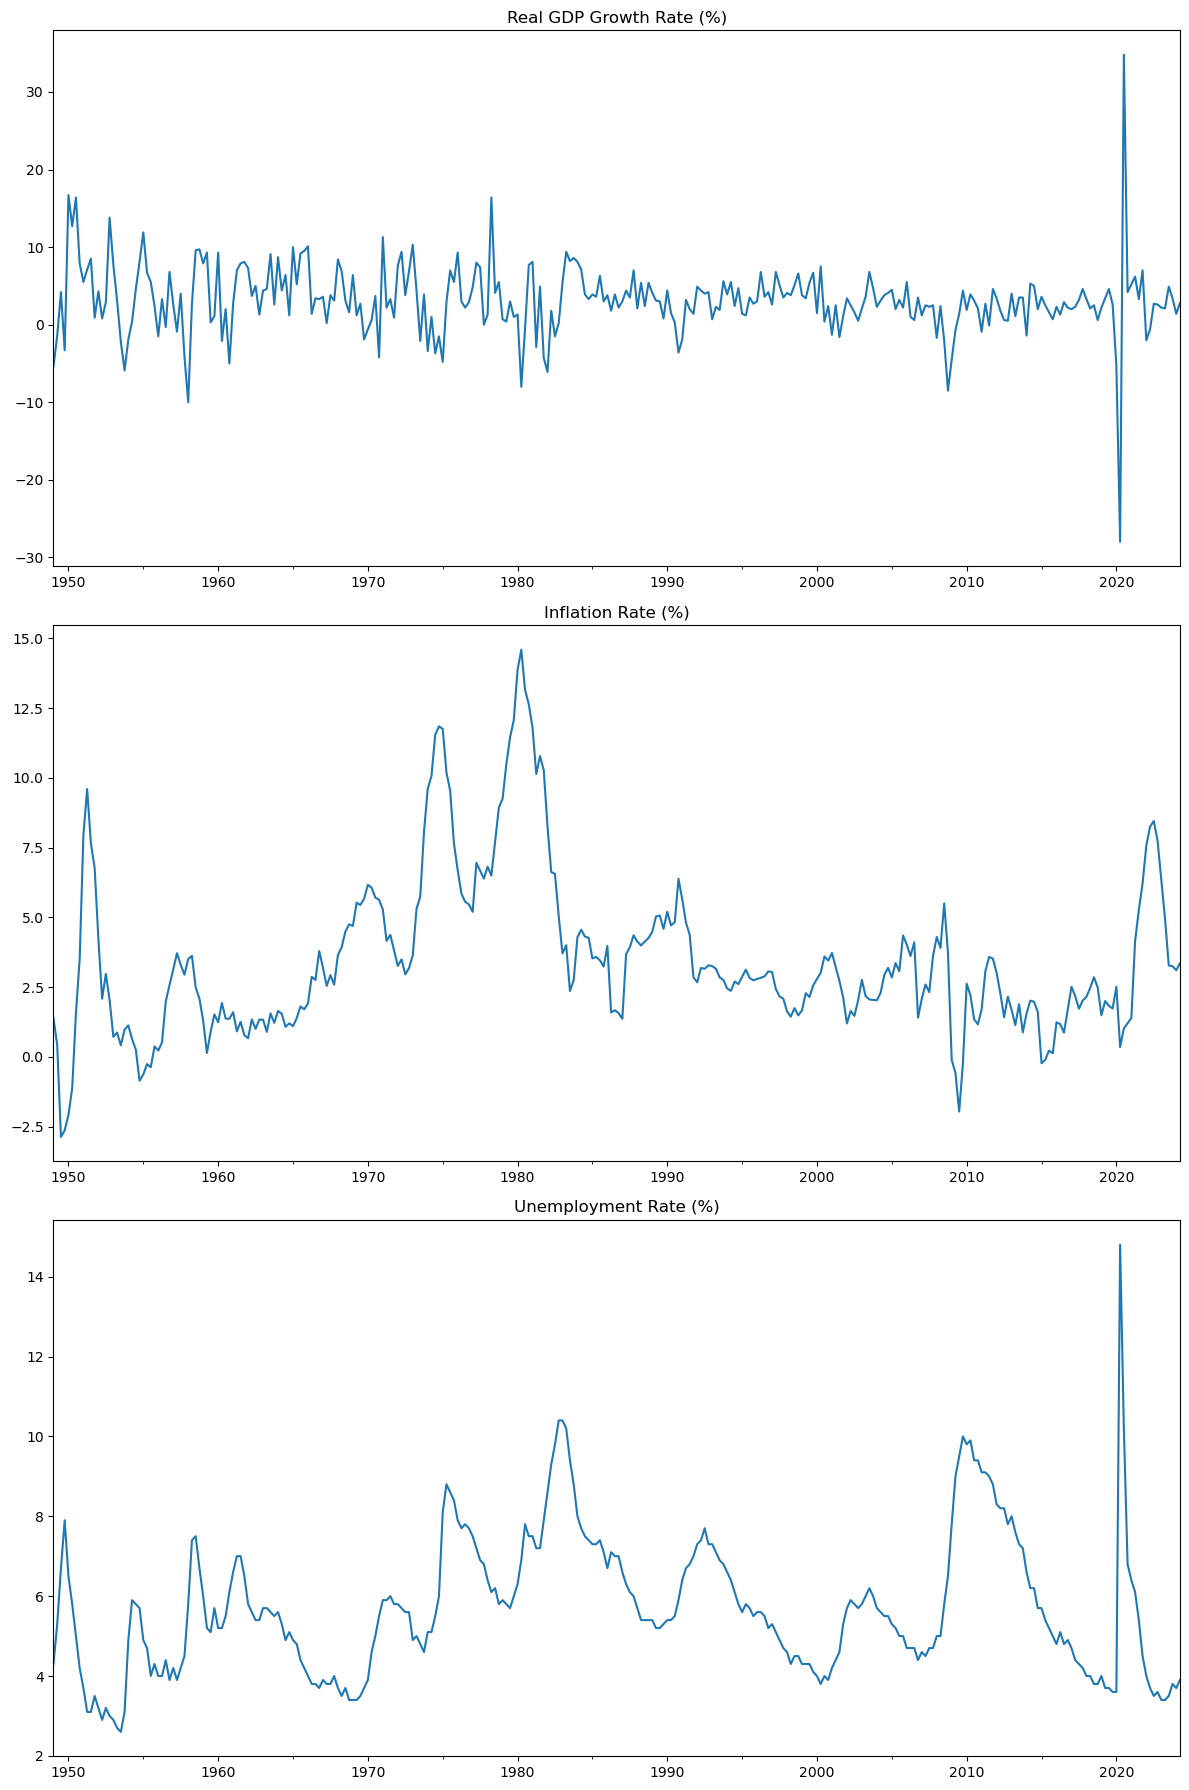

In [45]:
# Plot the data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
df['GDP_Growth'].plot(ax=axes[0], title='Real GDP Growth Rate (%)')
df['Inflation'].plot(ax=axes[1], title='Inflation Rate (%)')
df['Unemployment'].plot(ax=axes[2], title='Unemployment Rate (%)')
plt.tight_layout()
plt.show()

In [46]:
# Check for stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

for column in df.columns:
    print(f"\nADF Test for {column}:")
    adf_test(df[column])


ADF Test for GDP_Growth:
ADF Statistic: -15.299480336119355
p-value: 4.332438346132566e-28
Critical Values:
	1%: -3.452263435801039
	5%: -2.871190526189069
	10%: -2.571911967527952

ADF Test for Inflation:
ADF Statistic: -1.7338288671868534
p-value: 0.41377247501341907
Critical Values:
	1%: -3.4535050041524245
	5%: -2.8717352599720294
	10%: -2.5722024776854417

ADF Test for Unemployment:
ADF Statistic: -4.267403673265455
p-value: 0.0005056293029824743
Critical Values:
	1%: -3.452263435801039
	5%: -2.871190526189069
	10%: -2.571911967527952


In [47]:
df_diff = df.diff().dropna()

# Re-check stationarity after differencing
for column in df_diff.columns:
    print(f"\nADF Test after differencing for {column}:")
    adf_test(df_diff[column])


ADF Test after differencing for GDP_Growth:
ADF Statistic: -7.537706363098228
p-value: 3.4431705352211165e-11
Critical Values:
	1%: -3.4535872903895797
	5%: -2.871771355211212
	10%: -2.5722217283277127

ADF Test after differencing for Inflation:
ADF Statistic: -6.68460461221683
p-value: 4.257266987624986e-09
Critical Values:
	1%: -3.4535050041524245
	5%: -2.8717352599720294
	10%: -2.5722024776854417

ADF Test after differencing for Unemployment:
ADF Statistic: -14.022351897780451
p-value: 3.552767722851301e-26
Critical Values:
	1%: -3.4524113009049935
	5%: -2.8712554127251764
	10%: -2.571946570731871


In [48]:
print("\nJohansen Cointegration Test:")
print(coint_johansen(df, 0, 1).eig)


Johansen Cointegration Test:
[0.33524722 0.0814238  0.03378988]


In [50]:
# Fit the VAR model with optimal lag selection
model = VAR(df_diff)
results = model.fit(ic='aic')

# Save the summary to a text file
with open('var_model_summary.txt', 'w') as f:
    f.write(str(results.summary()))

# Optional: Display the most relevant parts of the summary
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Aug, 2024
Time:                     13:34:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.50702
Nobs:                     289.000    HQIC:                   1.66307
Log likelihood:          -1278.00    FPE:                    3.01332
AIC:                      1.09880    Det(Omega_mle):         2.09936
--------------------------------------------------------------------
Results for equation GDP_Growth
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.002476         0.230005           -0.011           0.991
L1.GDP_Growth           -0.591555         0.079924           -7.401           0.000
L1.Inflation            -0.324829         0

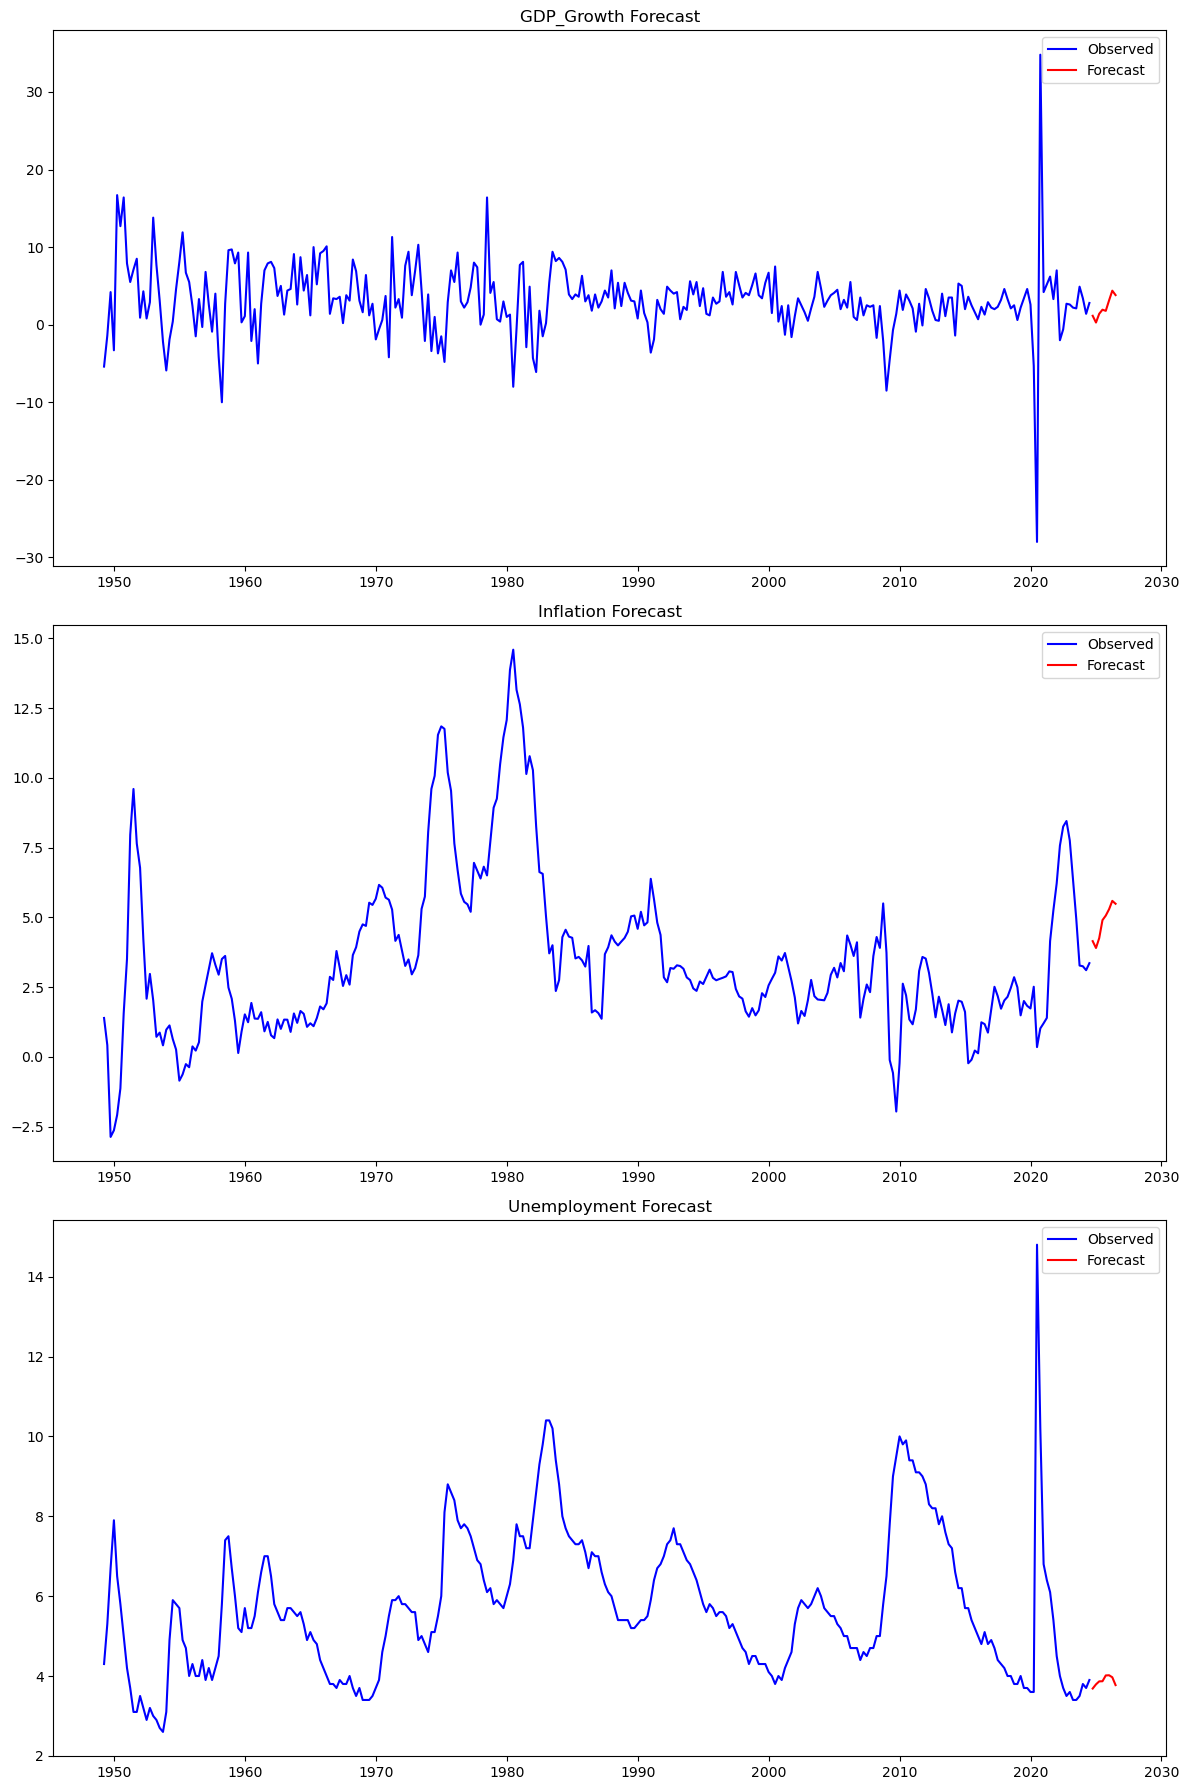

In [53]:
# Forecast using the VAR model
lag_order = results.k_ar
forecast_input = df_diff.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=8)

# Create a DataFrame for the forecasted differenced values
forecast_df = pd.DataFrame(forecast, 
                           index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=8, freq='Q'),
                           columns=df.columns + '_diff')

# Convert forecasted differences back to original levels
# Add the last observed value from the original series to the forecasted cumulative sum
forecast_df_levels = forecast_df.cumsum() + df.iloc[-1].values

# Plot forecasts alongside observed data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col], label='Observed', color='blue')
    axes[i].plot(forecast_df_levels.index, forecast_df_levels[col + '_diff'], label='Forecast', color='red')
    axes[i].set_title(f'{col} Forecast')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [54]:
print("Forecasted Values (Differenced):")
print(forecast_df)

print("Forecasted Values (Original Scale):")
print(forecast_df_levels)

Forecasted Values (Differenced):
            GDP_Growth_diff  Inflation_diff  Unemployment_diff
2024-09-30        -1.654174        0.788585          -0.213811
2024-12-31        -0.869220       -0.245483           0.104564
2025-03-31         1.127853        0.353213           0.075048
2025-06-30         0.528656        0.644719           0.003066
2025-09-30        -0.150350        0.163063           0.145422
2025-12-31         1.349671        0.227901           0.004274
2026-03-31         1.251261        0.299478          -0.050080
2026-06-30        -0.568351       -0.103819          -0.196394
Forecasted Values (Original Scale):
            GDP_Growth_diff  Inflation_diff  Unemployment_diff
2024-09-30         1.145826        4.146317           3.686189
2024-12-31         0.276606        3.900834           3.790753
2025-03-31         1.404459        4.254047           3.865801
2025-06-30         1.933115        4.898766           3.868867
2025-09-30         1.782765        5.061830      

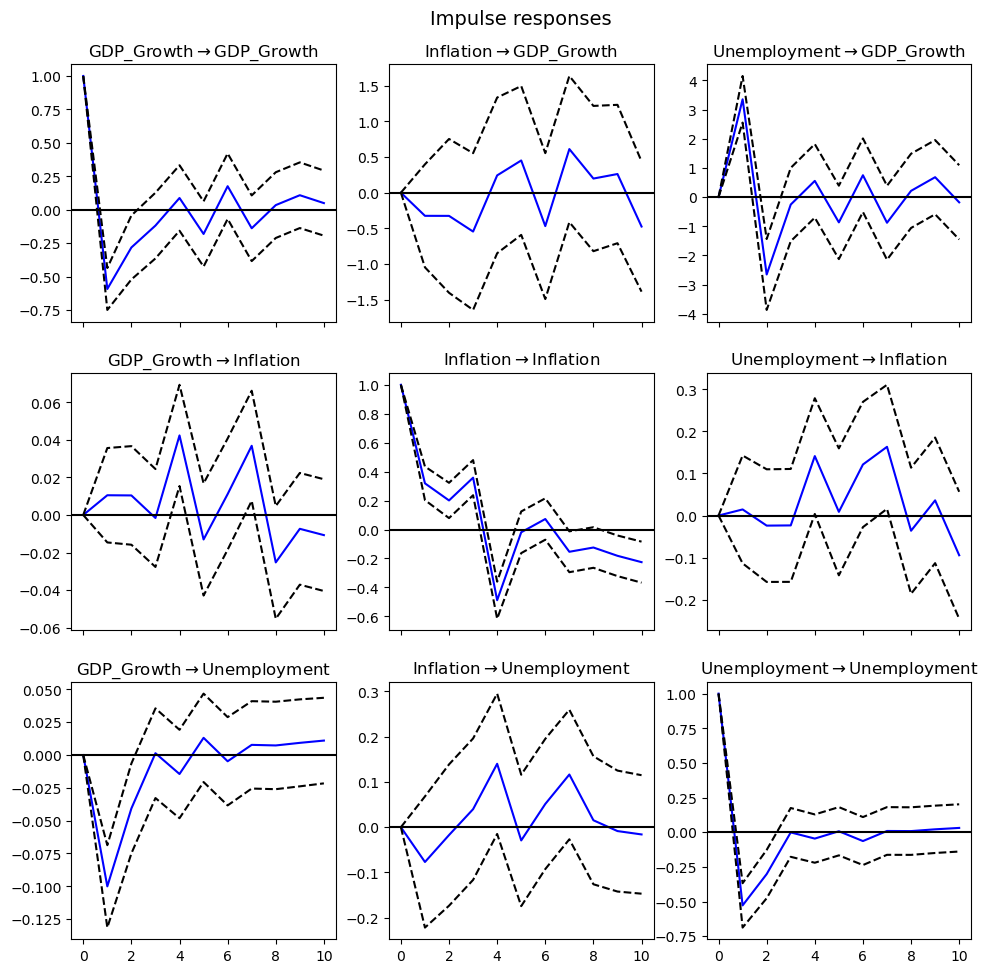

In [55]:
# Impulse Response Analysis
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

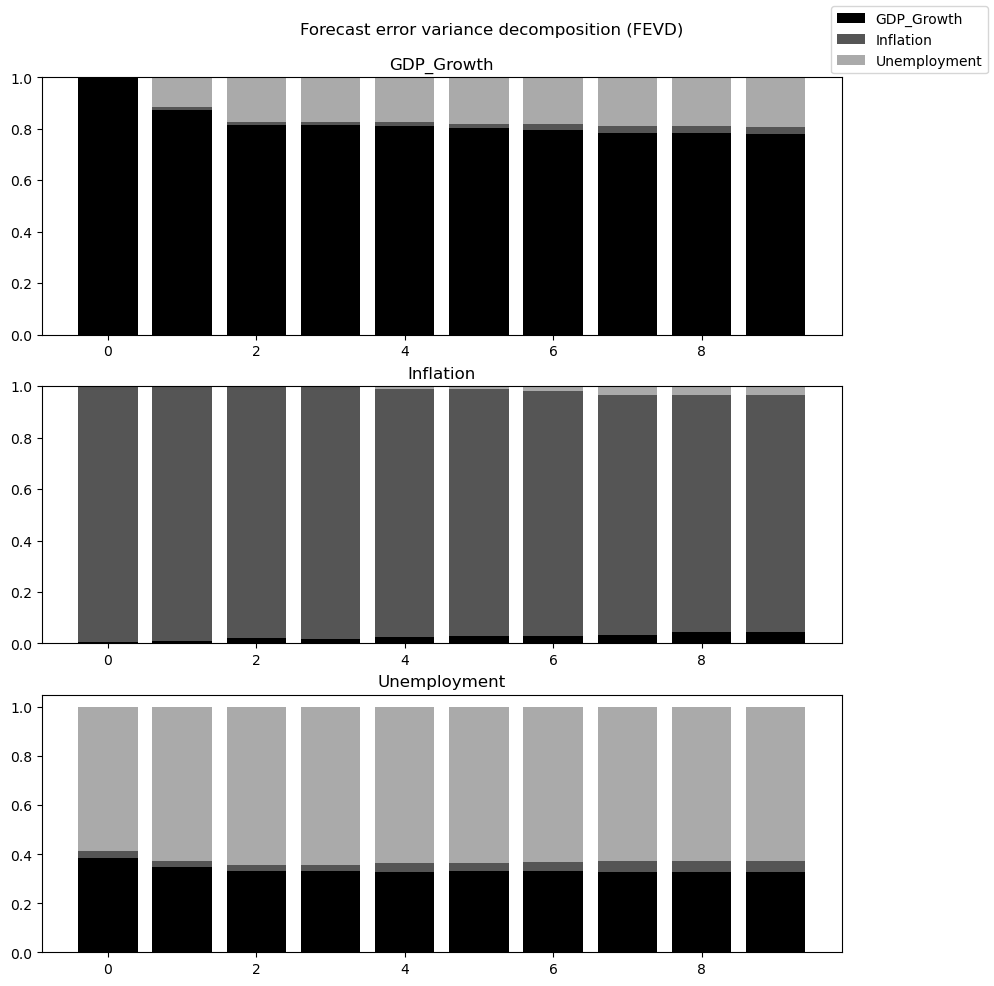

In [56]:
# Forecast Error Variance Decomposition
fevd = results.fevd(10)
fevd.plot()
plt.show()

In [60]:
# Perform Granger Causality test: Does Inflation cause GDP_Growth?
caused = 'GDP_Growth'
causing = 'Inflation'

print(f"\nGranger Causality Test: Does {causing} cause {caused}?")
test_result = results.test_causality(caused=caused, causing=causing, kind='f')
print(test_result.summary())


Granger Causality Test: Does Inflation cause GDP_Growth?
Granger causality F-test. H_0: Inflation does not Granger-cause GDP_Growth. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.9628          1.765   0.483 (12, 756)
-----------------------------------------------
